# First model for Graph Partitioning in Connected Components

## Problem statement

Let 
* $G = (V,E)$ be an undirected graph, with $V = \{1,\ldots, n\}$ being its node set, and $E \subset \{ \{i,j\}:\, i,j\in V, i \neq j \}$ being its edge set. 
* $ d: E \to \mathbb{R}^{+}$ be a cost function, 
* $k\geq 2$ an integer denoting the fixed number of connected components to partition $G$ into,
* $\alpha \geq 2$ an integer numbers representing the minimum cardinality of each connected component.

A $k$-partition of $V$ is a set $\{V_1,V_2,\ldots,V_k\}$ where $V_i\cap V_j=\emptyset$ for all $i\neq j$, $\bigcup_{c=1}^k V_c=V$, and $V_c \neq \emptyset$ for all $ c \in [k]$, where $[k]$ denotes the set $\{1,\ldots,k\}$. 


The partitioning problem in connected components with minimum size constraints consists of finding a  $k$-partition $\{V_1,V_2,\ldots,V_k\}$ such that each subset $V_c$ induces a connected subgraph, with $|V_c| \geq \alpha$, and the total cost of the edges with end nodes in the same subset of the partition is minimized.


Observe that each connected component of $G$ will have at most $\beta := n-(k-1)\alpha$ nodes. Moreover,  $\alpha$ has to be less than $ \left\lceil \frac{n}{k} \right\rceil$, otherwise the problem is infeasible.

* $y_i^c$ is a binary variable taking the value of one if the node $i \in V$ belongs to $V_c$, for some $c \in [k]$, and zero otherwise;
* $x_{ij}^c$ takes the value of one if the edge $\{i,j\} \in E$ links nodes $i$ and $j$ in the subset $V_c$, and zero otherwise;
* $\bar{x}_{ij}^c$ is defined for each $\{i,j\} \not\in E$ taking the value of one if nodes $i$ and $j$ belong to the same cluster $c$, and zero otherwise;
* $f_{i,j}^{\ell c}$ is a continuous variable representing the flow over the arc $(i,j)$ with source in the node $\ell$ on the induced subgraph $(V_c,E(V_c))$. 

Here each edge $\{i,j\}$ has two associated antiparallel arcs, namely $(i,j)$ and $(j,i)$. Also, sets $\delta_j^−$ and $\delta_j^+$ contain ingoing and outgoing arcs to the node $j$, respectively. 

\begin{align}
\min &\sum_{c\in [k]}\sum_{\{i,j\} \in E} d_{ij}\, x_{ij}^{c}
\\
\text{s.t.}\qquad & 
\\
&\sum_{c\in [K]} y_i^{c} = 1, &&\forall i \in V,
\\
&y_i^{c}+y_j^{c}-x_{ij}^{c} \leq 1,    &&\forall \{i,j\}\in E, c \in [k],
\\
&y_i^{c}+y_j^{c}-2x_{ij}^{c} \geq 0,       &&\forall \{i,j\}\in E, c \in [k],
\\
&y_i^{c}+y_j^{c}-\bar{x}_{ij}^{c} \leq 1,    &&\forall \{i,j\}\notin E,  c \in [k],
\\
&y_i^{c}+y_j^{c}-2\bar{x}_{ij}^{c} \geq 0,       &&\forall \{i,j\}\notin E, c \in [k],
\\
&\sum_{\ell \in V} f_{ij}^{\ell c}+f_{ji}^{\ell c} \leq (2nk)\, x_{ij}^{c},  &&\forall \{i,j\}\in E, c \in [k],
\\
&\sum_{\{i,j\} \in \delta_j^-} f_{ij}^{\ell c} - \sum_{\{j,i\} \in \delta_j^+} f_{j,i}^{\ell c}
= \begin{cases} 
            -\sum_{\{j,i\}\not\in E} \bar{x}_{ji}^{c} &\text{if } j = \ell   \\
            0 & \text{if } \{\ell,j\} \in E   \\
            \bar{x}_{\ell j}^{c}, &\text{otherwise}
  \end{cases}
&&\forall j,l \in V,c\in[k], 
\\
&\sum_{i\in V} y_i^{c} \geq \alpha,               &&\forall c \in [k].
\end{align}

## Implementation

In [1]:
from   gurobipy   import *
import pandas as pd    # https://pandas.pydata.org/
import numpy  as np    # Numpy
import igraph as ig    # iGraph
import time
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [2]:
#from InstancesGenerator import Graph_Instance      # Not needed
from warnings     import warn
from os           import listdir
from re           import findall

from collections  import deque, Counter
from itertools    import chain 
from numpy.random import default_rng
from matplotlib   import cm

An instance is selected. For more information about the available instances, see [```Instance generator NB.ipynb```](Instance%20generator%20NB.ipynb) and the associated function [```InstancesGenerator.py```](InstancesGenerator.py).

In [3]:
ins = 'IEG(45)'

In [4]:
Instance_path = 'Instances/'
instance = [f[:-4] for f in listdir(Instance_path) if f.startswith(ins)][0]
k, α = [int(i) for i in findall(r'\((.*?)\)',instance)[-1].split(',')]
display(instance)

'IEG(45),(2,3)'

In [5]:
file   = 'Instances/{0},({1},{2}).pkl'.format(ins,k,α)

In [6]:
'''rng = default_rng(0)
#G = Graph_Instance('IEG(45)')
#G = ig.Graph.Tree(30,1);    G.es['w'] = rng.integers(1, 10, G.ecount(), endpoint=True)
#G = ig.Graph.Tree(30,3);    G.es['w'] = rng.integers(1, 10, G.ecount(), endpoint=True)
G = Graph_Instance(ins)
G.to_undirected()
G = G.simplify(combine_edges='min')'''

G = ig.Graph.Read_Pickle(file)

In [7]:
A = G.get_edgelist() # edges
V = G.vs.indices     # nodes
n = G.vcount()
m = G.ecount()

print('(n,m) =', (n,m),'\nCost:',sum(G.es['w']))

(n,m) = (45, 228) 
Cost: 1313


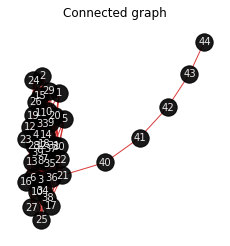

In [8]:
# Display graph
plt.figure(figsize=(3,3))
nx.draw(G.to_networkx(), nx.spring_layout(G.to_networkx(), seed=2), with_labels=True, 
        width=1, alpha=0.9, edge_color="tab:red",font_size=10, font_color="white",node_color="black")
plt.title('Connected graph' if G.is_connected() else 'Warning: unconnected graph')
plt.draw()

In [9]:
d = {a:G.es[G.get_eid(a[0],a[1])]['w'] for a in G.get_edgelist()}    # cost function
E = sorted(set(A))                                                   # Original edges in directed graph
Aᶜ = G.complementer(loops=False).get_edgelist()
Eᶜ = sorted(set(Aᶜ))                                                 # Edges not in original graph
TE = E+[(j,i) for (i,j) in E]                                        # All edges from complete graph

In [10]:
'''
k = 2;     K = tuplelist(range(k))    # Number of connected components
α = 3                                 # Minimum number of nodes per component
'''
K = tuplelist(range(k))               # Index of connected components
β = n - (k-1)*α                       # Maximum number of nodes per component
print('Created instance with (k,α) = ({0},{1}).'.format(
    k,α)) if α <= np.floor(n/k) else warn('\n\n*** α is too big! ***\n\n')

Created instance with (k,α) = (2,3).


In [11]:
# To improve numerics, we will divide the objective by
D = 1.0#/(2*k) #
D = 0.5 * sum(G.es['w']) / k

### Create model

In [12]:
if 'mo' in globals():        mo.dispose();    disposeDefaultEnv();    del mo

In [13]:
mo = Model()
x, x̄, y, f = tupledict(), tupledict(), tupledict(), tupledict()    # Dictionaries will contain variables

Set parameter Username

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2022-10-17


In [14]:
# *** Variables ***
# Link inside connected component #|x| = m * k
x = mo.addVars(E, K, vtype = 'B', name = 'x')
deque( (x[i,j,c].setAttr('obj', d[i,j]/D) for (i,j) in E for c in K), maxlen=0);    # Objective costs

# Indicator of connected component #|y| = n * k
y = mo.addVars(V, K, vtype = 'B', name = 'y')

# Connected component without direct link #|x̄| = (n*(n-1)//2 - m) * k
x̄ = mo.addVars(Eᶜ, K, vtype = 'B', name = 'x_c')

# Flow on induced graph #|f| = n*n*(n-1) * k
f = mo.addVars(TE, V, K, vtype = 'C', name = 'f')

In [15]:
mo.update()

In [16]:
# *** Constraints ***
# Each node must belong exactly to one cluster
mo.addConstrs((quicksum(y[i,c] for c in K) == 1 for i in V), name = 'R-1b-');
# If two nodes i,j ∈ V are assigned to Vₗ, then the edge {i,j} ∈ E belongs to the induced subgraph (Vₗ,E(Vₗ))
mo.addConstrs( (y[i,c]+y[j,c]-  x[i,j,c] <= 1.0 for (i,j) in E for c in K), name = 'R-1c-');
mo.addConstrs( (y[i,c]+y[j,c]-2*x[i,j,c] >= 0.0 for (i,j) in E for c in K), name = 'R-1d-');
# Connectivity between non-adjacent nodes within a connected component
mo.addConstrs( (y[i,c]+y[j,c]-  x̄[i,j,c] <= 1.0 for (i,j) in Eᶜ for c in K), name = 'R-1e-');
mo.addConstrs( (y[i,c]+y[j,c]-2*x̄[i,j,c] >= 0.0 for (i,j) in Eᶜ for c in K), name = 'R-1f-');
# Capacity for the antiparallel arcs associated to edge {i, j} ∈ E
mo.addConstrs((quicksum(f[i,j,l,c] + f[j,i,l,c] for l in V) <= (2*n*k) * x[i,j,c] for (i,j) in E for c in K), 
              name ='R-1g-');
# Flow conservation is ensured for all the nodes within the same connected component. One unit of flow is 
# sent through a path linking two nodes l, j ∈ V in the same connected component whenever {l,j} ∉ E. 
mo.addConstrs((quicksum(f[i,j,j,c] - f[j,i,j,c] for i in G.neighbors(j)) == quicksum(
                       -x̄[j,i,c] for i in V if (j,i) in Eᶜ)  for j in V for c in K), name = 'R-1h-a-');
'''mo.addConstrs((quicksum(f[i,j,l,c] - f[j,i,l,c] for i in G.neighbors(j)) == 0.0
               for j in V for l in V if ((l,j) in E and l<j)  for c in K), name = 'R-1h-b-');'''
mo.addConstrs((quicksum(f[i,j,l,c] - f[j,i,l,c] for i in G.neighbors(j)) == 0.0
               for (l,j) in E if l<j  for c in K), name = 'R-1h-b-');
'''FC = mo.addConstrs((quicksum(f[i,j,l,c] - f[j,i,l,c] for i in G.neighbors(j)) == x̄[l,j,c] 
         for j in V for l in V if (l != j and ((l,j) in Eᶜ)) for c in K), name = 'R-1h-c-');'''
FC = mo.addConstrs((quicksum(f[i,j,l,c] - f[j,i,l,c] for i in G.neighbors(j)) == x̄[l,j,c] 
               for (l,j) in Eᶜ if l<j for c in K), name = 'R-1h-b-');
# Lower bounds for the number of nodes present at each connected component
mo.addConstrs((quicksum(y[i,c] for i in V) >= α for c in K), name = 'R-1i-');

In [17]:
# Lazy constraints for flow conservation: Activate if needed
#for a in FC.keys():    FC[a].Lazy = 1

In [18]:
mo.Params.TimeLimit = 8*60
mo.optimize()

Set parameter TimeLimit to value 480
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 6533 rows, 43110 columns and 96456 nonzeros
Model fingerprint: 0xa3f40d9c
Variable types: 41040 continuous, 2070 integer (2070 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [3e-03, 3e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 395 rows and 15433 columns
Presolve time: 0.12s
Presolved: 6138 rows, 27677 columns, 80547 nonzeros
Variable types: 25572 continuous, 2105 integer (2025 binary)
Found heuristic solution: objective 3.4059406
Found heuristic solution: objective 1.9345011

Root relaxation: objective 0.000000e+00, 131 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


     0     0    1.09015    0 2028    1.21858    1.09015  10.5%     -   92s
     0     0    1.09032    0 2040    1.21858    1.09032  10.5%     -   93s
     0     0    1.09072    0 2044    1.21858    1.09072  10.5%     -   96s
     0     0    1.09160    0 2006    1.21858    1.09160  10.4%     -   99s
     0     0    1.09160    0 1632    1.21858    1.09160  10.4%     -  102s
     0     2    1.09160    0 1625    1.21858    1.09160  10.4%     -  105s
*   94    18               6       1.2063976    1.14214  5.33%   927  107s

Cutting planes:
  Gomory: 2
  Cover: 13
  Implied bound: 4
  Clique: 274
  MIR: 443
  Flow cover: 48
  Zero half: 255
  Network: 3
  RLT: 465
  Relax-and-lift: 4
  BQP: 149

Explored 143 nodes (443642 simplex iterations) in 108.18 seconds (201.96 work units)
Thread count was 8 (of 8 available processors)

Solution count 10: 1.2064 1.21858 1.22163 ... 1.29779

Optimal solution found (tolerance 1.00e-04)
Best objective 1.206397562833e+00, best bound 1.206397562833e+00, ga

In [19]:
Vₖ = {c:[i for i in V if y[i,c].x>0.0] for c in K}
print(Vₖ)

{0: [0, 1, 3, 4, 5, 6, 7, 11, 12, 13, 18, 19, 21, 23, 25, 26, 30, 35, 36, 38, 40, 41, 42, 43, 44], 1: [2, 8, 9, 10, 14, 15, 16, 17, 20, 22, 24, 27, 28, 29, 31, 32, 33, 34, 37, 39]}


In [20]:
[G.induced_subgraph(Vₖ[c]).is_connected() for c in K]

[True, True]

In [21]:
{c: D * sum(x[i,j,c].obj for (i,j) in E if x[i,j,c].x > 0.0) for c in K}

{0: 178.99999999999994, 1: 217.00000000000006}

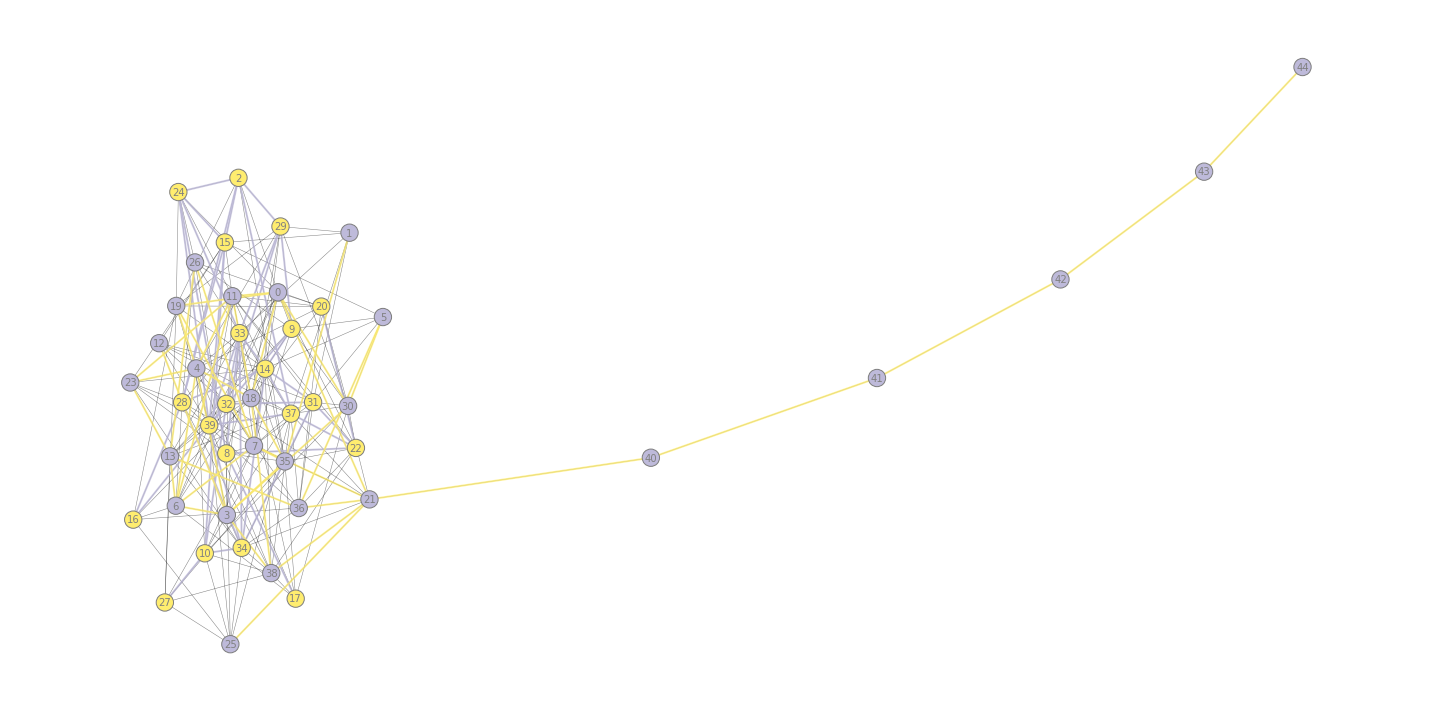

In [22]:
# Display graph with partitions
pos = nx.spring_layout(G.to_networkx(), seed=2)  # positions for all nodes
Col = cm.Set3(np.linspace(0.2, 1, k))

plt.figure(figsize=(20,10))
# Nodes
options = {"edgecolors": "tab:gray"}#, "node_size": 800, "alpha": 0.9}
for c in K:
    nx.draw_networkx_nodes(G.to_networkx(), pos, nodelist=Vₖ[c], node_color=[Col[c] for i in Vₖ[c]], **options)

# Edges
nx.draw_networkx_edges(G.to_networkx(), pos, width=0.5, alpha=0.5)
for c in K:
    Eₖ = [e.tuple for e in G.es if e.tuple[0] not in Vₖ[c] and e.tuple[1] not in Vₖ[c]]
    nx.draw_networkx_edges(
        G.to_networkx(), pos, edgelist=Eₖ,
        width=2, alpha=0.75,
        edge_color=[Col[c] for e in Eₖ],
    )

'''nx.draw(G.to_networkx(), pos, with_labels=True, 
        width=1, alpha=0.9, edge_color="tab:red",font_size=10, font_color="white",node_color="black")'''
nx.draw_networkx_labels(G, pos, {i:i for i in G.vs.indices}, font_size=10, font_color="gray")

plt.tight_layout()
plt.axis("off")
plt.draw()

In [23]:
Data = pd.DataFrame.from_dict(
    {'Instance':[(n,m,k,α)],
     'z_R':[mo.ObjBound * D],'Obj': mo.objval * D,'gap': mo.MIPgap,'nodes':int(mo.nodecount), 'time':mo.RunTime})
display(Data)

,Instance,z_R,Obj,gap,nodes,time
0,"(45, 228, 2, 3)",396.0,396.0,0.0,143,108.184323


In [24]:
name_out = 'Out[{0},{1},{2}]-M1'.format(ins,k,α)

In [25]:
with pd.ExcelWriter(name_out + '.xlsx') as writer:  
    Data.to_excel(writer, sheet_name='Sheet_1')
    pd.DataFrame.from_dict(Vₖ, orient='index').fillna('').to_excel(writer, sheet_name='Sheet_2')

---